In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preprocessing

In [2]:
from datetime import datetime

df = pd.read_csv("fraud test.csv")
df.head()

# dob to age
df['dob'] = pd.to_datetime(df['dob'], format="%d/%m/%Y")
today = pd.to_datetime("today")
df['age_years'] =  round((today - df['dob']).dt.days / 365, 1)

# Create time_period and is_weekend
df['transaction_datetime'] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')
df['weekday'] = df['transaction_datetime'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

df['hour'] = df['transaction_datetime'].dt.hour

def assign_time_period(hour):
    if hour >= 22 or hour <= 3:
        return 'Late Night'
    elif 4 <= hour <= 9:
        return 'Morning'
    elif 10 <= hour <= 15:
        return 'Afternoon'
    else:  # 16–21
        return 'Evening'

df['time_period'] = df['hour'].apply(assign_time_period)

# Drop non-useful columns
columns_to_drop = ['Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'trans_num', 
                   'merchant', 'dob', 'trans_date_trans_time', 'job', 'zip', 'lat', 
                   'long', 'merch_lat', 'merch_long', 'trans_date_trans_time', 'hour', 
                   'city','transaction_datetime', 'weekday', 'unix_time']
df.drop(columns=columns_to_drop, inplace=True)

# Reorder the DataFrame
new_column_order = [
    'gender', 'age_years', 'state', 'city_pop',        # personal info
    'category', 'amt', 'time_period', 'is_weekend',    # transaction features
    'is_fraud'
]

df = df[new_column_order]
df.head()

,gender,age_years,state,city_pop,category,amt,time_period,is_weekend,is_fraud
0,M,57.4,SC,333497,personal_care,2.86,Afternoon,1,0
1,F,35.5,UT,302,personal_care,29.84,Afternoon,1,0
2,F,54.8,NY,34496,health_fitness,41.28,Afternoon,1,0
3,M,38.0,FL,54767,misc_pos,60.05,Afternoon,1,0
4,M,70.1,MI,1126,travel,3.19,Afternoon,1,0


### Data Encoding

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()

time_map = {
    'Morning': 0,
    'Afternoon': 1,
    'Evening': 2,
    'Late Night': 3
}
df_encoded['time_period'] = df_encoded['time_period'].map(time_map)

le_gender = LabelEncoder()
le_category = LabelEncoder()
le_state = LabelEncoder()

df_encoded['gender'] = le_gender.fit_transform(df_encoded['gender'])
df_encoded['category'] = le_category.fit_transform(df_encoded['category'])
df_encoded['state'] = le_state.fit_transform(df_encoded['state'])

# MinMax Scaling for continuous features
scaler = MinMaxScaler()
df_encoded[['city_pop', 'amt', 'age_years']] = scaler.fit_transform(
    df_encoded[['city_pop', 'amt', 'age_years']]
)

df_encoded.head()


,gender,age_years,state,city_pop,category,amt,time_period,is_weekend,is_fraud
0,1,0.459527,39,0.114727,10,0.000082,1,1,0
1,0,0.186800,43,0.000096,10,0.001267,1,1,0
2,0,0.427148,33,0.011860,5,0.001769,1,1,0
3,1,0.217933,8,0.018834,9,0.002594,1,1,0
4,1,0.617684,21,0.000379,13,0.000096,1,1,0


In [4]:
import joblib

# Save LabelEncoders
joblib.dump(le_gender, 'le_gender.pkl')
joblib.dump(le_category, 'le_category.pkl')
joblib.dump(le_state, 'le_state.pkl')

# Save MinMaxScaler
joblib.dump(scaler, 'scaler.pkl')

# Save time_map
joblib.dump(time_map, 'time_map.pkl')

['time_map.pkl']

In [ ]:
fraud_df = df_encoded[df_encoded['is_fraud'] == 1]
nonfraud_df = df_encoded[df_encoded['is_fraud'] == 0].sample(n=8000, random_state=42)
balanced_df = pd.concat([fraud_df, nonfraud_df])

x = balanced_df.drop(columns=['is_fraud'])
y = balanced_df['is_fraud']

# --- Step 11: Split train/test sets ---
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)
x_train.shape, x_test.shape

((8116, 8), (2029, 8))

### MODEL WITHOUT SMOTE

In [6]:
# --- Step 12: Train logistic regression model ---
lr_model = LogisticRegression(max_iter=2000, solver='liblinear')
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=2000, solver='liblinear')

In [7]:
# --- Step 13: Predict and evaluate ---
y_pred = lr_model.predict(x_test)
print("Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Results:
[[1583   17]
 [ 258  171]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1600
           1       0.91      0.40      0.55       429

    accuracy                           0.86      2029
   macro avg       0.88      0.69      0.74      2029
weighted avg       0.87      0.86      0.84      2029



In [8]:
# --- Step 14: Train random forest model ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# --- Step 15: Predict and evaluate ---
y_rf_pred = rf_model.predict(x_test)
print("\nRandom Forest Results:")
print(confusion_matrix(y_test, y_rf_pred))
print(classification_report(y_test, y_rf_pred))


Random Forest Results:
[[1585   15]
 [  25  404]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1600
           1       0.96      0.94      0.95       429

    accuracy                           0.98      2029
   macro avg       0.97      0.97      0.97      2029
weighted avg       0.98      0.98      0.98      2029



### MODEL WITH SMOTE

In [10]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Perform oversampling on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print("Before SMOTE:", x_train.shape, y_train.value_counts().to_dict())
print("After SMOTE:", X_train_resampled.shape, y_train_resampled.value_counts().to_dict())


Before SMOTE: (8116, 8) {0: 6400, 1: 1716}
After SMOTE: (12800, 8) {0: 6400, 1: 6400}


d:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [11]:
lr_model_smote = LogisticRegression(max_iter=2000, solver='liblinear')
lr_model_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=2000, solver='liblinear')

In [12]:
# --- Step 13: Predict and evaluate ---
y_pred = lr_model_smote.predict(x_test)
print("Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Results:
[[1258  342]
 [  48  381]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      1600
           1       0.53      0.89      0.66       429

    accuracy                           0.81      2029
   macro avg       0.75      0.84      0.76      2029
weighted avg       0.87      0.81      0.82      2029



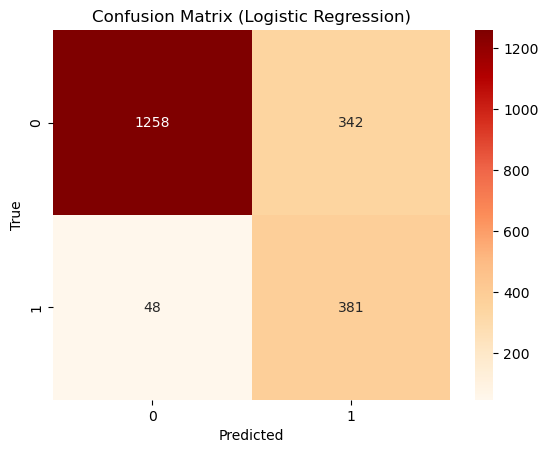

In [13]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd')
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

       Feature  Coefficient
5          amt    29.459678
6  time_period     1.187797
3     city_pop    -1.181867
1    age_years     0.548236
0       gender    -0.299328
7   is_weekend    -0.290198
2        state    -0.005360
4     category     0.001104


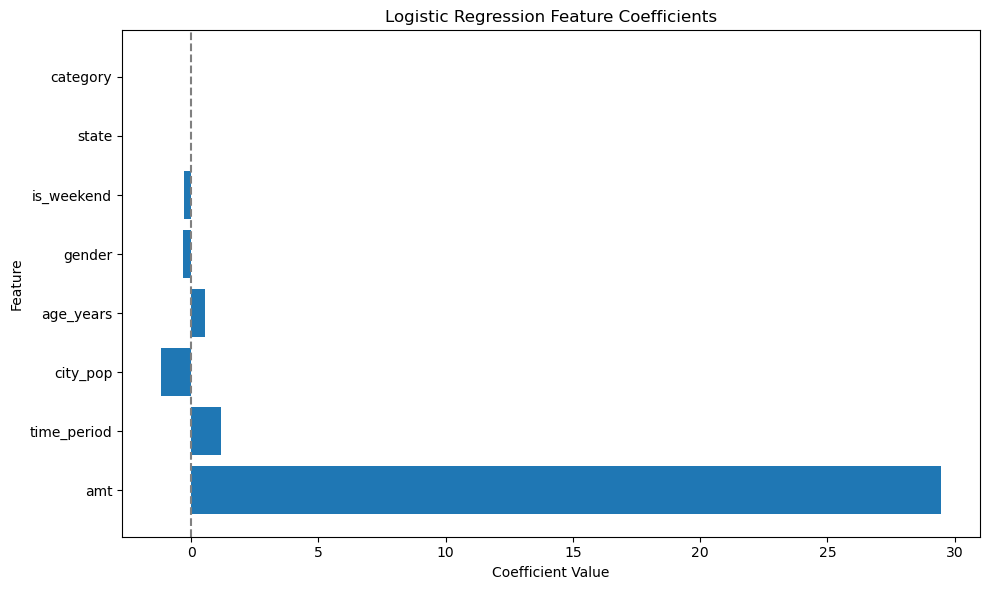

In [14]:
# Extract model coefficients
coefficients = lr_model_smote.coef_[0]

# Retrieve feature names
feature_names = X_train_resampled.columns

# Create a DataFrame of feature importances
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort features by absolute coefficient values
coeff_df['AbsCoefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='AbsCoefficient', ascending=False)

# Display top features
print(coeff_df[['Feature', 'Coefficient']])

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'])
plt.axvline(0, color='gray', linestyle='--')
plt.title('Logistic Regression Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


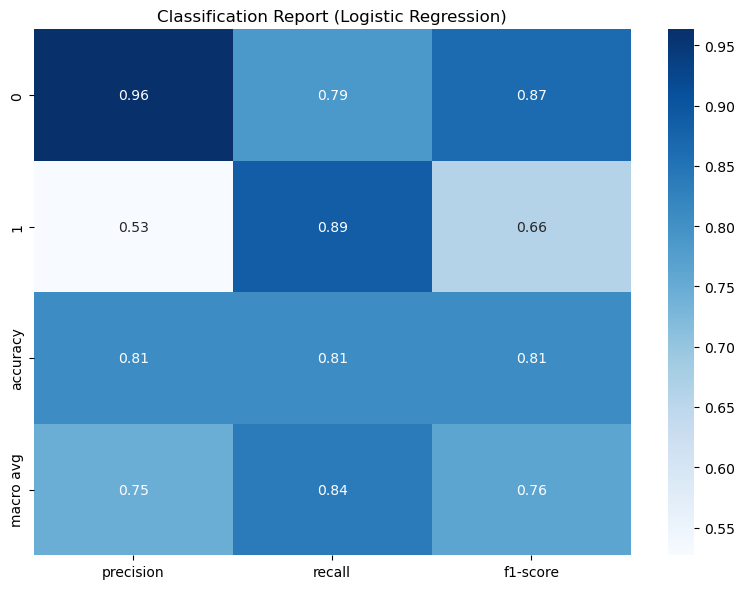

In [15]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report (Logistic Regression)")
plt.tight_layout()
plt.show()

In [16]:
# --- Step 14: Train random forest model ---
rf_model_somte = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_somte.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [17]:
# --- Step 15: Predict and evaluate ---
y_rf_pred = rf_model_somte.predict(x_test)
print("\nRandom Forest Results:")
print(confusion_matrix(y_test, y_rf_pred))
print(classification_report(y_test, y_rf_pred))


Random Forest Results:
[[1555   45]
 [  19  410]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1600
           1       0.90      0.96      0.93       429

    accuracy                           0.97      2029
   macro avg       0.94      0.96      0.95      2029
weighted avg       0.97      0.97      0.97      2029



In [18]:
# Save Random Forest model
joblib.dump(rf_model_somte, 'rf_model_smote.pkl')

# Save Logistic Regression model
joblib.dump(lr_model_smote, 'lr_model_smote.pkl')

joblib.dump(x_test, 'x_test.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

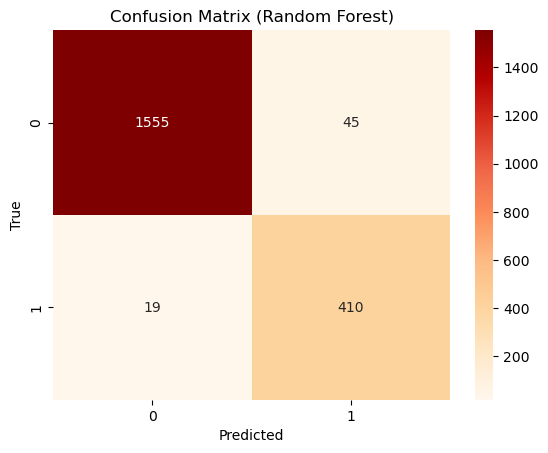

In [19]:
cm = confusion_matrix(y_test, y_rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd')
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

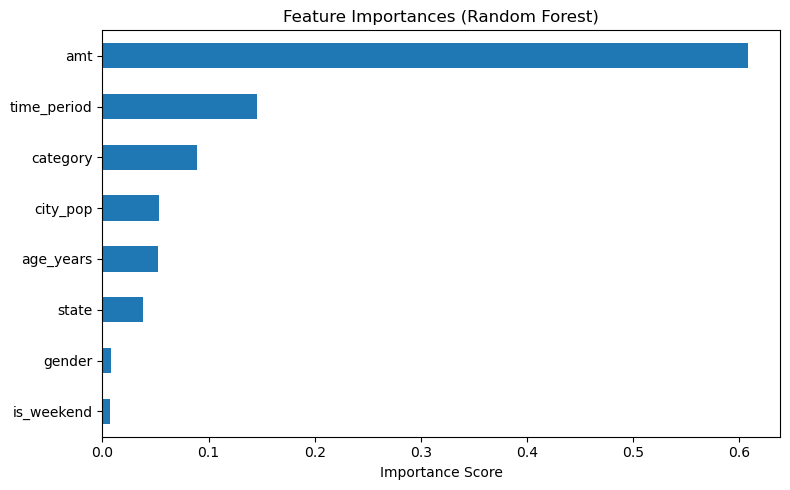

In [20]:
importances = rf_model.feature_importances_
features = x_train.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
feat_imp.plot(kind='barh')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

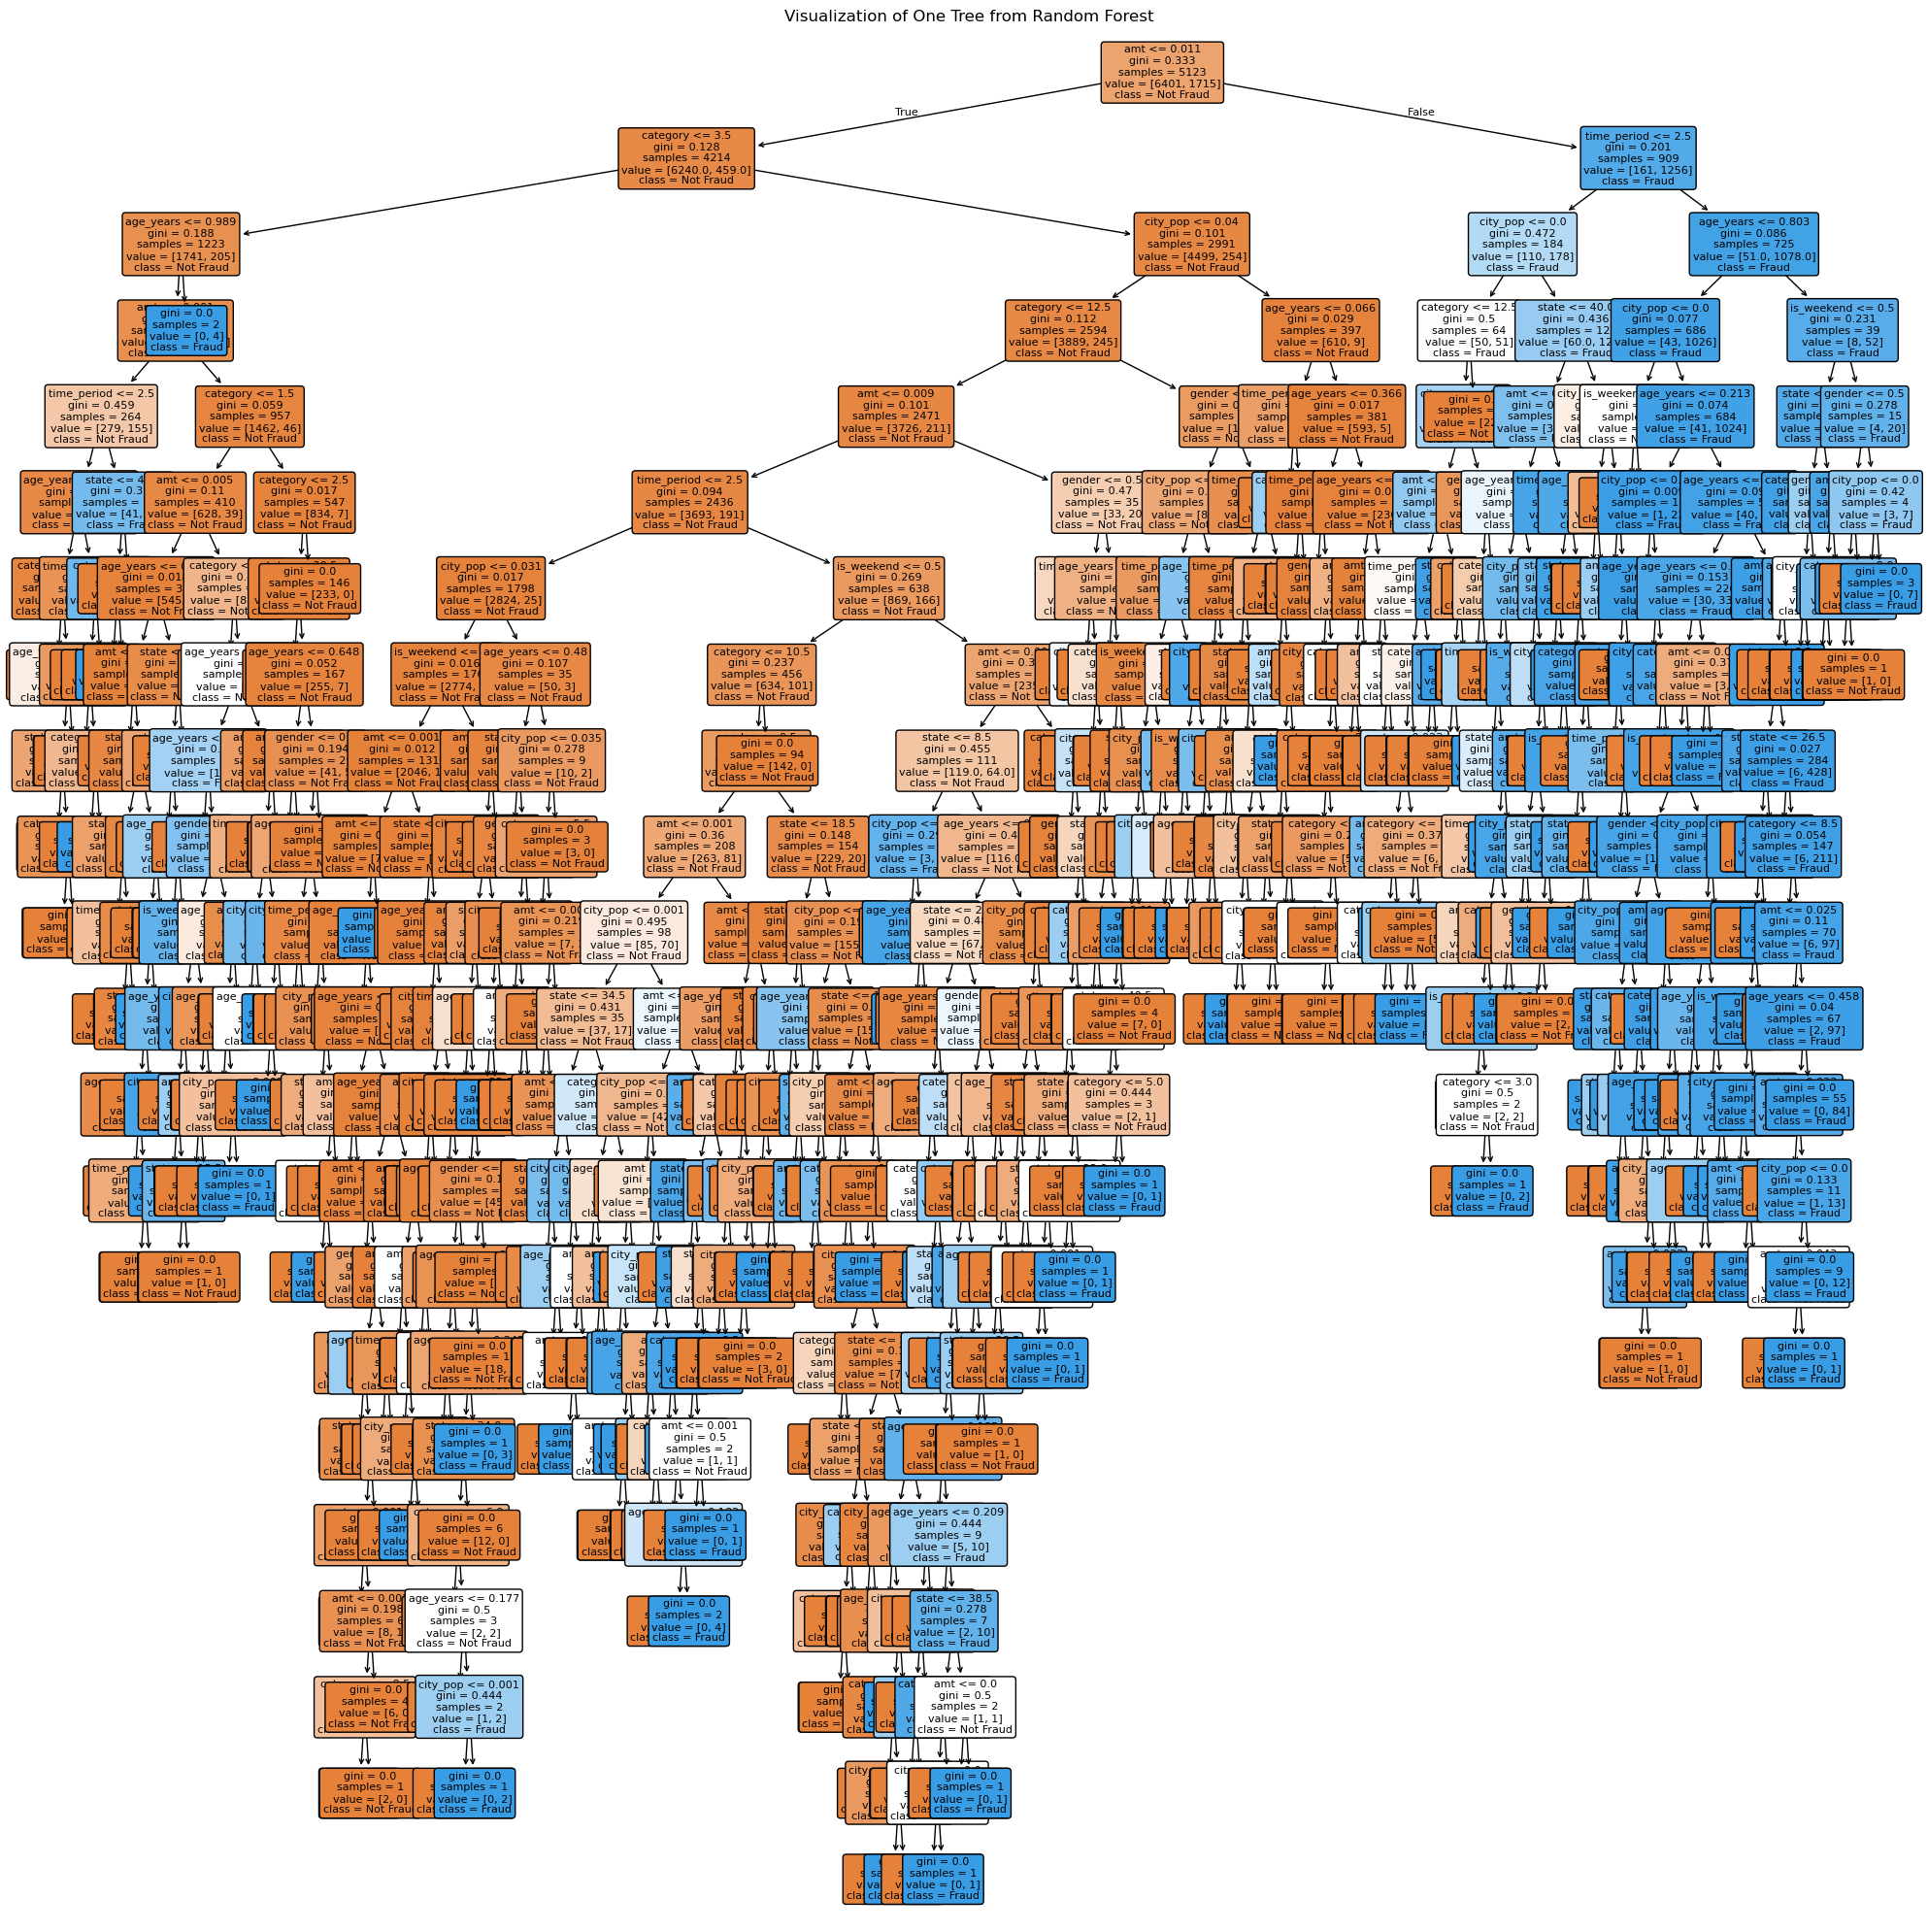

In [21]:
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

# Select the first tree from the trained Random Forest model
estimator = rf_model.estimators_[0]

plt.figure(figsize=(20, 20))
plot_tree(estimator,
          feature_names=x_train.columns,
          class_names=["Not Fraud", "Fraud"],
          filled=True,
          rounded=True,
          fontsize=8)
plt.title("Visualization of One Tree from Random Forest")
plt.tight_layout()
plt.show()

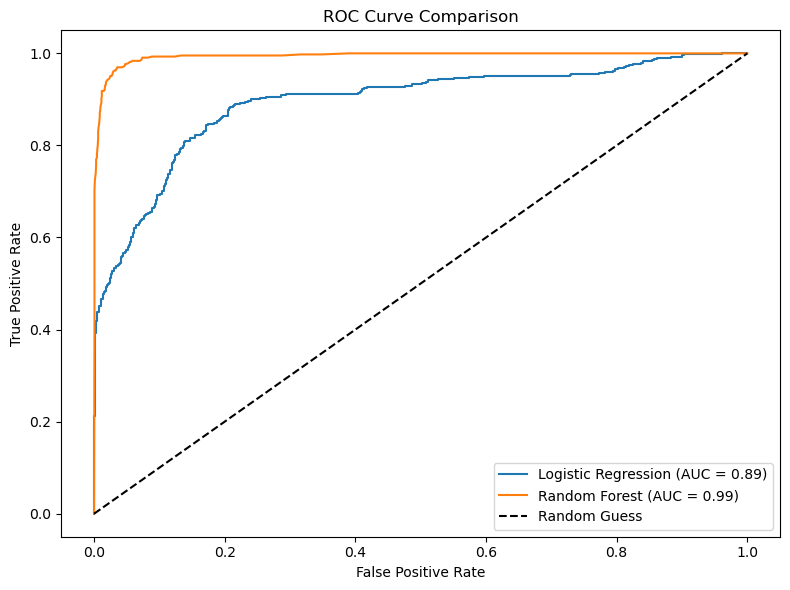

In [22]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_score_lr = lr_model_smote.predict_proba(x_test)[:, 1]
y_score_rf = rf_model_somte.predict_proba(x_test)[:, 1]

# Retrieve true labels
y_true = y_test

# Calculate fpr, tpr, auc
fpr_lr, tpr_lr, _ = roc_curve(y_true, y_score_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_true, y_score_rf)

auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.tight_layout()
plt.show()

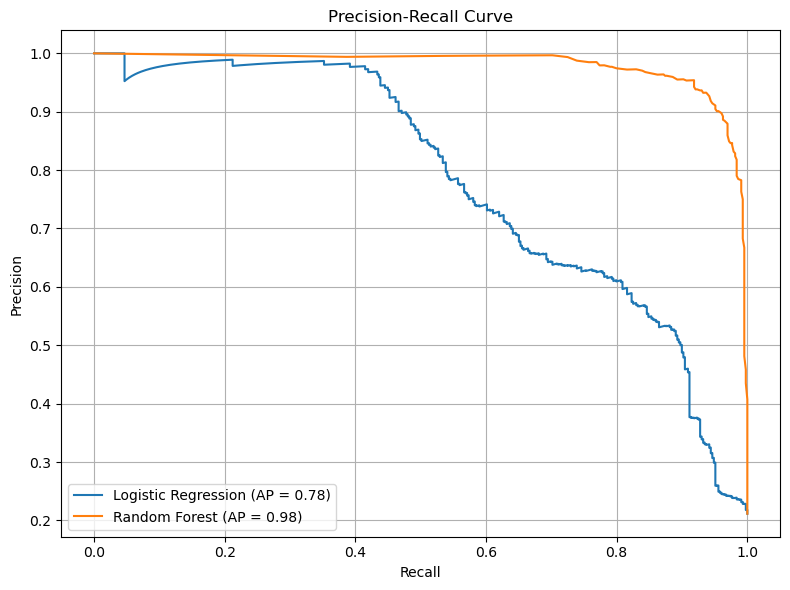

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Prepare data for the Precision-Recall curve
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_score_lr)
rf_precision, rf_recall, _ = precision_recall_curve(y_test, y_score_rf)

# Calculate average precision score
lr_ap = average_precision_score(y_test, y_score_lr)
rf_ap = average_precision_score(y_test, y_score_rf)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(lr_recall, lr_precision, label=f"Logistic Regression (AP = {lr_ap:.2f})")
plt.plot(rf_recall, rf_precision, label=f"Random Forest (AP = {rf_ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

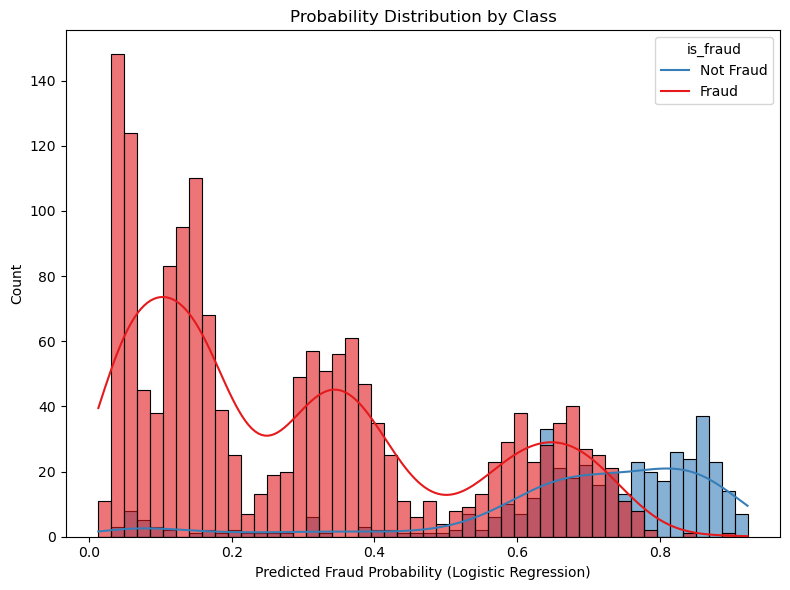

In [ ]:
# Predict fraud probabilities using Logistic Regression
lr_probs = lr_model_smote.predict_proba(x_test)[:, 1]

# Add the prediction probabilities as a new column in the DataFrame
df_probs = x_test.copy()
df_probs['is_fraud'] = y_test.values
df_probs['fraud_prob_lr'] = lr_probs

# Plot the results with 'is_fraud' as the color indicator
plt.figure(figsize=(8, 6))
sns.histplot(data=df_probs, x='fraud_prob_lr', hue='is_fraud', bins=50, kde=True, palette='Set1', alpha=0.6)
plt.xlabel("Predicted Fraud Probability (Logistic Regression)")
plt.title("Probability Distribution by Class")
plt.legend(title="is_fraud", labels=["Not Fraud", "Fraud"])
plt.tight_layout()
plt.show()

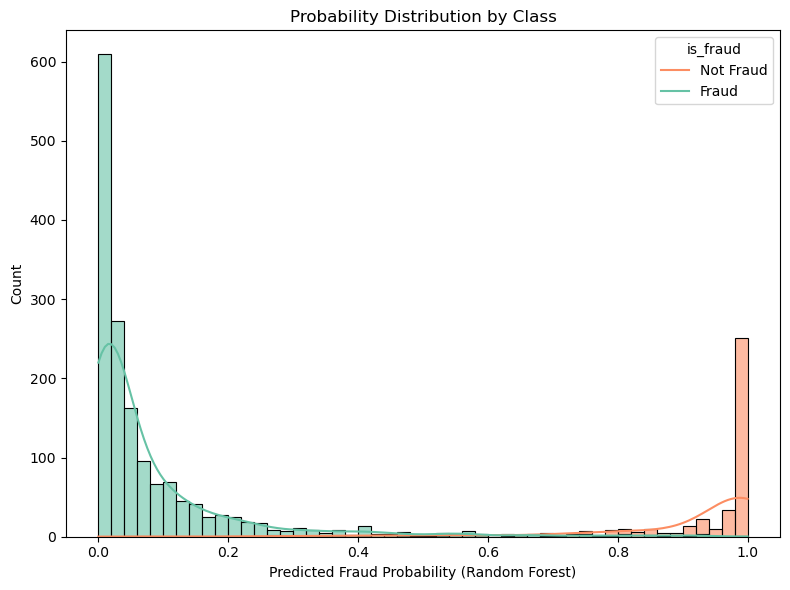

In [ ]:
# Predict fraud probabilities using Random Forest
rf_probs = rf_model_somte.predict_proba(x_test)[:, 1]
df_probs['fraud_prob_rf'] = rf_probs

plt.figure(figsize=(8, 6))
sns.histplot(data=df_probs, x='fraud_prob_rf', hue='is_fraud', bins=50, kde=True, palette='Set2', alpha=0.6)
plt.xlabel("Predicted Fraud Probability (Random Forest)")
plt.title("Probability Distribution by Class")
plt.legend(title="is_fraud", labels=["Not Fraud", "Fraud"])
plt.tight_layout()
plt.show()

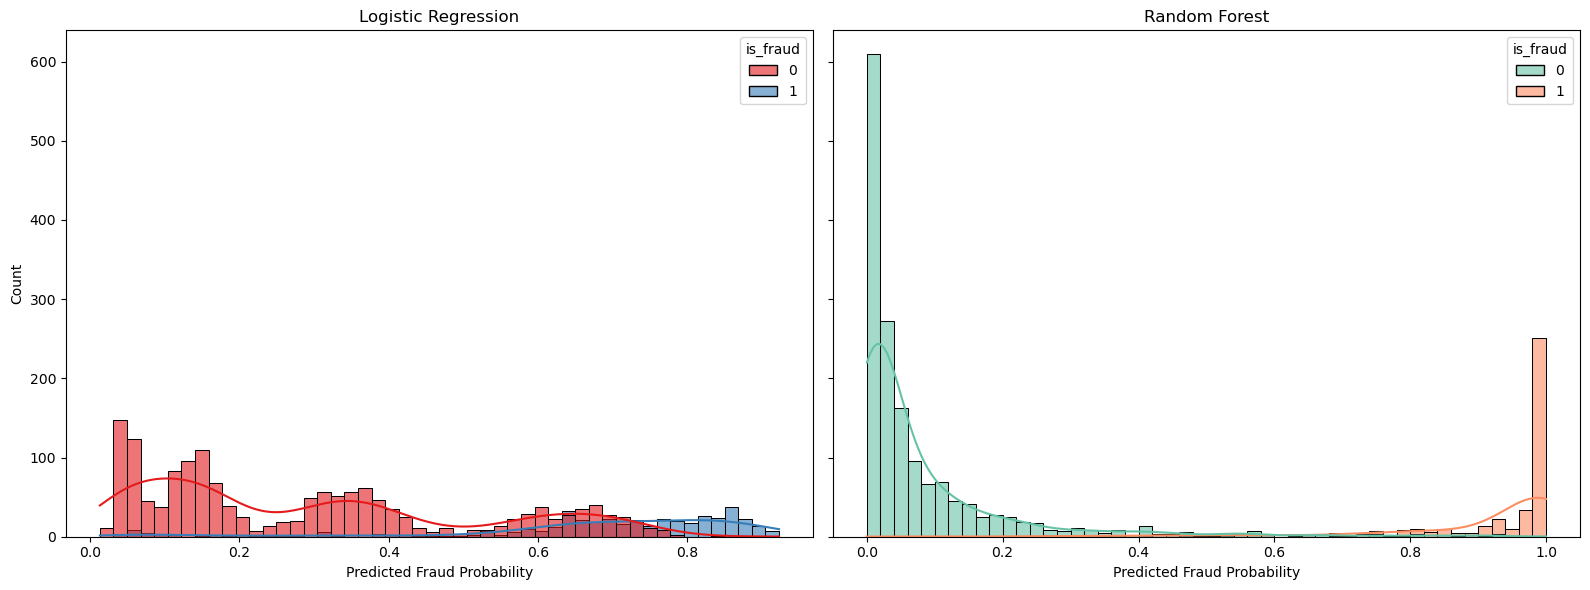

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Logistic Regression
sns.histplot(data=df_probs, x='fraud_prob_lr', hue='is_fraud', bins=50, kde=True, palette='Set1', alpha=0.6, ax=axes[0])
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted Fraud Probability")

# Random Forest
sns.histplot(data=df_probs, x='fraud_prob_rf', hue='is_fraud', bins=50, kde=True, palette='Set2', alpha=0.6, ax=axes[1])
axes[1].set_title("Random Forest")
axes[1].set_xlabel("Predicted Fraud Probability")

plt.tight_layout()
plt.show()

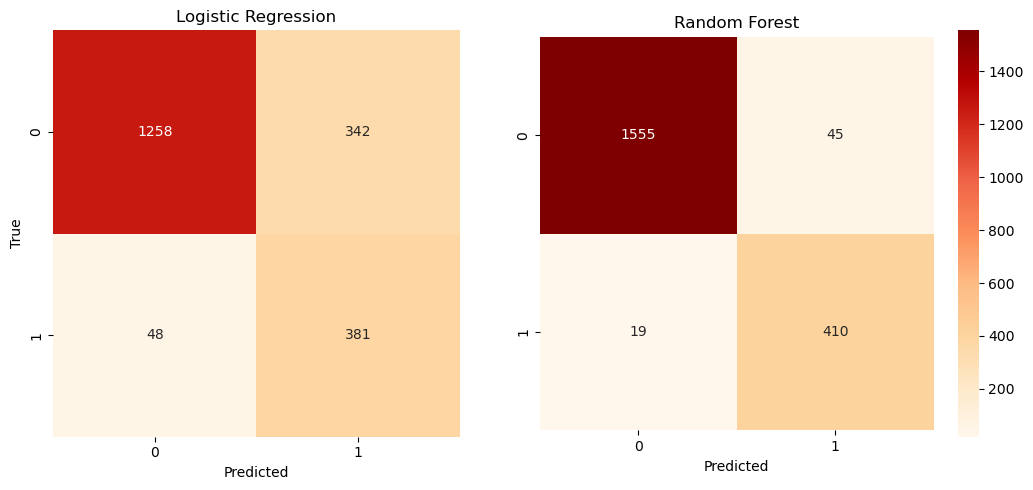

In [ ]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred)
cm_rf = confusion_matrix(y_test, y_rf_pred)

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
vmin = min(cm_lr.min(), cm_rf.min())
vmax = max(cm_lr.max(), cm_rf.max())
# Logistic Regression
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='OrRd', ax=axs[0], cbar=False, square=True, vmin=vmin, vmax=vmax)
axs[0].set_title('Logistic Regression')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

# Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='OrRd', ax=axs[1], square=True, vmin=vmin, vmax=vmax)
axs[1].set_title('Random Forest')
axs[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()